# STARBUCKS CAPSTONE
The dataset simulates customer interactions on the Starbucks Rewards mobile app. Periodically, Starbucks sends offers to users through the app. These offers range from simple advertisements for drinks to promotional deals like discounts or buy-one-get-one-free (BOGO). However, not every user receives an offer each week, and the types of offers sent vary among users. The goal is to analyze this dataset to identify which demographic groups are most responsive to specific offer types.

The challenge lies in integrating transaction, demographic, and offer data to discern patterns in customer responses. Although the dataset is a simplified version of the real app experience, focusing on a single product type, it still provides valuable insights. Each offer in the dataset has a set validity period during which it can be redeemed. For example, a BOGO offer might only be redeemable within five days. Informational offers also have validity periods, during which the customer is likely influenced by the ad, even if it’s just an informational message about a product.

The transactional data includes records of purchases made through the app, noting the time of purchase and the amount spent. It also tracks each offer a user receives, views, and completes. Importantly, customers can still make purchases without receiving or viewing any offer.
## Problem Statement :
The problem statement involves predicting which type of offer will elicit the strongest customer response or lead to actions such as ‘offer received,’ ‘offer viewed,’ ‘transaction,’ or ‘offer completed,’ using customer demographic data and offer attributes.

### Importing Libraries & Loading Datasets 

In [7]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.jsonl', orient='records', lines=True)
profile = pd.read_json('data/profile.jsonl', orient='records', lines=True)
transcript = pd.read_json('data/transcript.jsonl', orient='records', lines=True)

In [8]:
portfolio.head(3) 

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [9]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [10]:
profile.head(3) 

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


### Data Accessing and Cleaning:
#### 1. Portfolio Data

**Dataset Overview:**

- **File:** `portfolio.json`
- **Fields:**
  - **id (string):** Unique identifier for each offer.
  - **offer_type (string):** Type of the offer, such as BOGO (Buy-One-Get-One), discount, or informational.
  - **difficulty (int):** Minimum amount of money a user must spend to qualify for the offer.
  - **reward (int):** Incentive given upon successful completion of the offer.
  - **duration (int):** The period, in days, during which the offer is active.
  - **channels (list of strings):** Different platforms through which the offer can be distributed.

There are three main types of offers in this dataset: Buy-One-Get-One (BOGO), discount, and informational.

- **BOGO (Buy-One-Get-One):** Requires the user to spend a specified amount, which then unlocks a reward equivalent to that amount.
- **Discount:** Grants a reward proportional to the amount the user spends, effectively reducing the cost of purchases.
- **Informational:** No monetary reward is associated with this type, nor is there any spending requirement; it serves purely as a product advertisement.


In [11]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
portfolio.shape

(10, 6)

In [13]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [14]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [15]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

### Data Cleaning - Portfolio

In [16]:

# Make a copy of the original dataframe for further processing.
df_portfolio = portfolio.copy()

# Split the 'channels' column into separate columns for each channel type.
channels_expanded = df_portfolio['channels'].apply(lambda x: pd.Series(1, index=x)).fillna(0)

# Merge the expanded channels with the original dataframe.
df_portfolio = df_portfolio.join(channels_expanded)

# Drop the original 'channels' column.
df_portfolio.drop(columns='channels', inplace=True)

# Rename the 'id' column to 'offer_id'.
df_portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

df_portfolio


,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0


### 2. Profile Data
**Dataset Overview:**

- **File:** `profile.json`
- **Fields:**
  - **age (int):** The age of the customer.
  - **became_member_on (int):** The date when the customer registered for an app account.
  - **gender (str):** The gender of the customer, where some entries include 'O' for other, in addition to 'M' (Male) and 'F' (Female).
  - **id (str):** Unique identifier for each customer.
  - **income (float):** The income level of the customer.


In [17]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [18]:
profile.shape   

(17000, 5)

In [19]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [20]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [21]:
profile.duplicated().sum()

0

### Data Cleaning - Profile

In [22]:
# Data Cleaning
# Create a copy of the original profile dataframe for further processing.
df_profile = profile.copy()

# Convert the 'became_member_on' column to a datetime format.
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')

# Rename the 'id' column to 'customer_id'.
df_profile.rename(columns={'id': 'customer_id'}, inplace=True)

# Display the first 10 rows of the cleaned dataframe.
df_profile.head(10)


,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,2016-11-22,NaN


### 3. Transcript Data
**Dataset Overview:**

- **File:** `transcript.json`
- **Fields:**
  - **event (str):** Description of the recorded activity (e.g., transaction, offer received, offer viewed, etc.).
  - **person (str):** Unique identifier for the customer.
  - **time (int):** Time in hours since the start of the experiment, beginning at t=0.
  - **value (dict of strings):** Contains either an offer id or a transaction amount, depending on the type of record.


In [23]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [24]:
transcript.shape

(306534, 4)

In [25]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [26]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [27]:
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [28]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [29]:
transcript['event'].value_counts()


event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

### Data Cleaning - Transcript

In [30]:
# Data Cleaning
# Create a copy of the original transcript dataframe for further manipulation.
df_transcript = transcript.copy()

# Rename the 'person' column to 'customer_id'.
df_transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# Replace spaces in the 'event' column with hyphens.
df_transcript['event'] = df_transcript['event'].str.replace(' ', '-')

# Display the count of each unique event type.
event_counts = df_transcript['event'].value_counts()
print(event_counts)

# Create dummy variables for the 'event' column.
event_dummies = pd.get_dummies(df_transcript['event'])

# Concatenate the dummy variables to the original dataframe.
df_transcript = pd.concat([df_transcript, event_dummies], axis=1)

# Display the first few rows of the modified dataframe.
df_transcript.head()


event
transaction        138953
offer-received      76277
offer-viewed        57725
offer-completed     33579
Name: count, dtype: int64


,customer_id,event,value,time,offer-completed,offer-received,offer-viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,False,True,False,False
1,a03223e636434f42ac4c3df47e8bac43,offer-received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,False,True,False,False
2,e2127556f4f64592b11af22de27a7932,offer-received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,False,True,False,False
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,False,True,False,False
4,68617ca6246f4fbc85e91a2a49552598,offer-received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,False,True,False,False


In [31]:
df_transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df_transcript.value]
df_transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df_transcript.value]
df_transcript = df_transcript.drop(columns='value')
df_transcript.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,False,True,False,False,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,False,True,False,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,False,True,False,False,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,False,True,False,False,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Data Manipulation

In [33]:
df_merge_transcript_profile = pd.merge(df_transcript, df_profile, on='customer_id')
df_merge_transcript_profile

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,False,True,False,False,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,False,True,False,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,118,2017-08-04,NaN
2,e2127556f4f64592b11af22de27a7932,offer-received,0,False,True,False,False,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,False,True,False,False,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,118,2017-09-25,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-10-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,False,False,False,True,None,1.59,M,66,2018-01-01,47000.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,False,False,False,True,None,9.53,M,52,2018-04-08,62000.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,False,False,False,True,None,3.61,F,63,2013-09-22,52000.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,False,False,False,True,None,3.53,M,57,2016-07-09,40000.0


In [35]:
df_all = pd.merge(df_merge_transcript_profile, df_portfolio, on='offer_id', how='left')
df_all

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,False,True,False,False,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,False,True,False,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,...,2017-08-04,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer-received,0,False,True,False,False,2906b810c7d4411798c6938adc9daaa5,NaN,M,...,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,False,True,False,False,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,...,2017-09-25,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,...,2017-10-02,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,False,False,False,True,None,1.59,M,...,2018-01-01,47000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,False,False,False,True,None,9.53,M,...,2018-04-08,62000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,False,False,False,True,None,3.61,F,...,2013-09-22,52000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,False,False,False,True,None,3.53,M,...,2016-07-09,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Create a unique list of offer IDs
offer_id = df_all['offer_id'].unique()

# Create a dictionary that maps offer IDs to numerical indices
offer_dict = {offer: idx for idx, offer in enumerate(offer_id)}

# Map the offer IDs in the dataframe to their corresponding indices using the dictionary
df_all['offer_id'] = df_all['offer_id'].map(offer_dict)

# Display the first few rows of the dataframe to confirm the changes
df_all.head()

# Replace the index associated with None (which was mapped to 1) with NaN
df_all['offer_id'].replace(offer_dict[None], np.nan, inplace=True)

# Display the first few rows of the dataframe after replacing None with NaN
df_all.head()


C:\Users\feyza.cotuk\AppData\Local\Temp\ipykernel_592\328840962.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['offer_id'].replace(offer_dict[None], np.nan, inplace=True)


,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,False,True,False,False,0.0,NaN,F,...,2017-05-09,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,False,True,False,False,1.0,NaN,None,...,2017-08-04,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer-received,0,False,True,False,False,2.0,NaN,M,...,2018-04-26,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,False,True,False,False,3.0,NaN,None,...,2017-09-25,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,False,True,False,False,4.0,NaN,None,...,2017-10-02,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [37]:
df_all['offer_id'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

In [40]:
# Get the unique event types
event_ids = df_all['event'].unique()

# Create a dictionary that maps each event type to a numerical index
event_dict = {event: idx for idx, event in enumerate(event_ids)}

# Map the event types in the dataframe to their corresponding indices using the dictionary
df_all['event_id'] = df_all['event'].map(event_dict)

# Display the first few rows of the dataframe to confirm the changes
df_all.head()


,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,False,True,False,False,0.0,NaN,F,...,100000.0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,False,True,False,False,1.0,NaN,None,...,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,0,False,True,False,False,2.0,NaN,M,...,70000.0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,False,True,False,False,3.0,NaN,None,...,NaN,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,False,True,False,False,4.0,NaN,None,...,NaN,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,0


In [41]:
df_all.shape

(306534, 22)

In [42]:
df_all.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [43]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   event             306534 non-null  object        
 2   time              306534 non-null  int64         
 3   offer-completed   306534 non-null  bool          
 4   offer-received    306534 non-null  bool          
 5   offer-viewed      306534 non-null  bool          
 6   transaction       306534 non-null  bool          
 7   offer_id          167581 non-null  float64       
 8   amount            138953 non-null  float64       
 9   gender            272762 non-null  object        
 10  age               306534 non-null  int64         
 11  became_member_on  306534 non-null  datetime64[ns]
 12  income            272762 non-null  float64       
 13  reward            167581 non-null  float64       
 14  diff

In [45]:
df_all.to_csv('data/data.csv', index=False)

In [46]:
data = pd.read_csv('data/data.csv')

### Data Exploration and Visualization

**Data Exploration:**
- Analyze dataset structure, check for missing values, and summarize key statistics.
- Identify patterns, trends, and relationships between variables.

**Data Visualization:**
- Use histograms, bar charts, and scatter plots to visualize data distributions and relationships.
- Highlight key insights with visual tools to support analysis.


In [47]:
data.age.describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

C:\Users\feyza.cotuk\AppData\Local\Temp\ipykernel_592\783120529.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


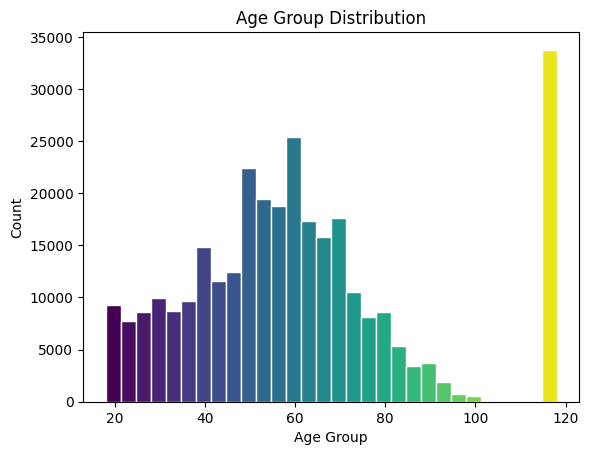

In [51]:
# Create a figure object
fig = plt.figure()

# Add a subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Generate the histogram data
n, bins, patches = ax.hist(data.age, bins=30, edgecolor='white')

# Set the color for each bin
for i, patch in enumerate(patches):
    patch.set_facecolor(plt.cm.viridis(i / len(patches)))

# Set the labels and title
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')
ax.set_title('Age Group Distribution')

# Display the interactive plot
fig.show()


### Observation

- **Outliers Identified:** A significant number of users have an age greater than 115, which is likely erroneous.
- **Typical User Age:** The majority of users are middle-aged, with the average age falling between 50 and 62 years.


In [52]:
data.income.describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

C:\Users\feyza.cotuk\AppData\Local\Temp\ipykernel_592\309730343.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


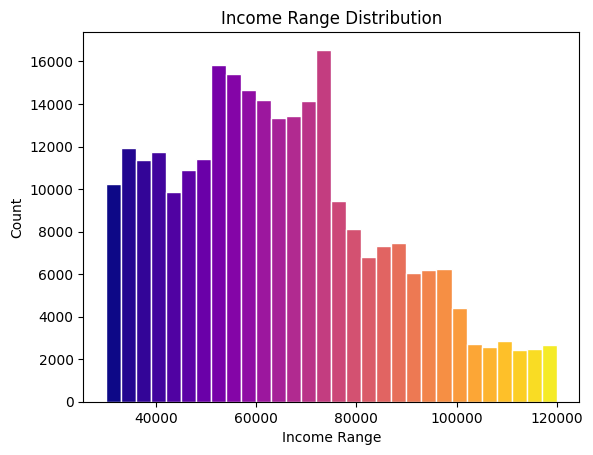

In [53]:
# Create a figure object
fig = plt.figure()

# Add a subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Generate the histogram data
n, bins, patches = ax.hist(data.income, bins=30, edgecolor='white')

# Set different colors for each bin using a color map
for i, patch in enumerate(patches):
    patch.set_facecolor(plt.cm.plasma(i / len(patches)))

# Set the labels and title
ax.set_xlabel('Income Range')
ax.set_ylabel('Count')
ax.set_title('Income Range Distribution')

# Display the interactive plot
fig.show()

### Observation

- **Average Income:** The typical user falls within the middle-income group, with an average income ranging between $65,000 and $70,000.


In [54]:
data.gender.value_counts()

gender
M    155690
F    113101
O      3971
Name: count, dtype: int64

In [55]:
# Calculate the proportion of each gender group
male_proportion = (data.gender.value_counts(normalize=True)['M'] * 100)
female_proportion = (data.gender.value_counts(normalize=True)['F'] * 100)
others_proportion = (data.gender.value_counts(normalize=True)['O'] * 100)

male_proportion, female_proportion, others_proportion


(57.0790652656895, 41.465086778950145, 1.4558479553603507)

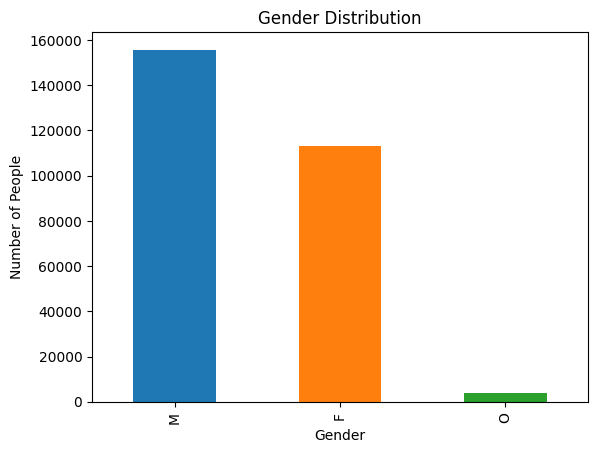

In [56]:
# Get the gender counts
ax = data.gender.value_counts()

# Create a bar plot with custom colors
ax.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Set the labels and title
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution')

# Display the plot
plt.show()

### Observation

- **Gender Distribution:** Males constitute more than 50% of the user base.


In [57]:
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()

offer_received , offer_viewed , offer_completed 

(offer_type
 discount         30543
 bogo             30499
 informational    15235
 Name: count, dtype: int64,
 offer_type
 bogo             25449
 discount         21445
 informational    10831
 Name: count, dtype: int64,
 offer_type
 discount    17910
 bogo        15669
 Name: count, dtype: int64)

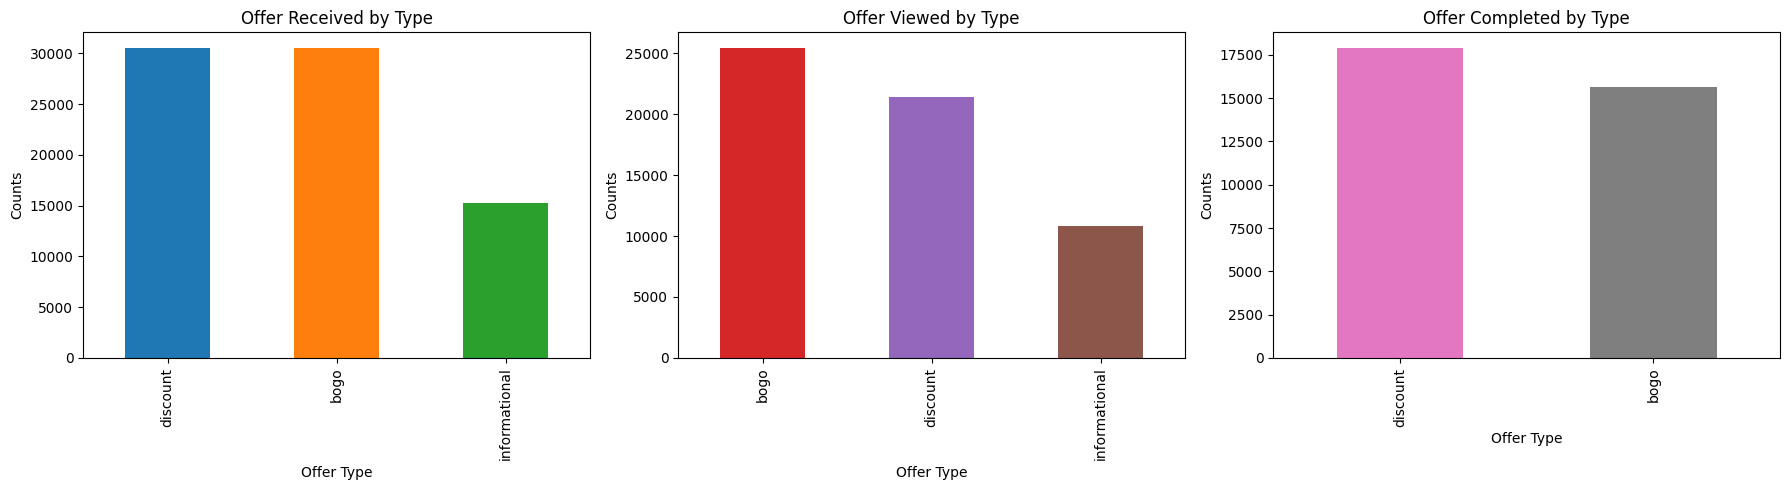

In [58]:
# Create a figure and an array of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for Offer Received
offer_received = data[data['offer-received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', ax=axs[0], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Offer Type')
axs[0].set_title('Offer Received by Type')

# Plot for Offer Viewed
offer_viewed = data[data['offer-viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar', ax=axs[1], color=['#d62728', '#9467bd', '#8c564b'])
axs[1].set_ylabel('Counts')
axs[1].set_xlabel('Offer Type')
axs[1].set_title('Offer Viewed by Type')

# Plot for Offer Completed
offer_completed = data[data['offer-completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar', ax=axs[2], color=['#e377c2', '#7f7f7f', '#bcbd22'])
axs[2].set_ylabel('Counts')
axs[2].set_xlabel('Offer Type')
axs[2].set_title('Offer Completed by Type')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [59]:
# For BOGO Offer

# Extract values for the BOGO offer type
R = offer_received['bogo']
V = offer_viewed['bogo']
C = offer_completed['bogo']

# Calculate the view and completion proportions
view_prop = V / R
com_prop = C / R

# Display the values
R, V, C, view_prop, com_prop


(30499, 25449, 15669, 0.8344208006819895, 0.5137545493294862)

In [60]:
# For DISCOUNT Offer

# Extract values for the DISCOUNT offer type
R = offer_received['discount']
V = offer_viewed['discount']
C = offer_completed['discount']

# Calculate the view and completion proportions
view_prop = V / R
com_prop = C / R

# Display the values
R, V, C, view_prop, com_prop


(30543, 21445, 17910, 0.702124873129686, 0.5863864060504862)

### Observation

- **BOGO Offers:** BOGO offers are highly popular. Out of 30,499 users who received a BOGO offer, 25,449 viewed it, and 15,669 completed it.
- **BOGO Offer Viewership:** The percentage of users who viewed the BOGO offer is 83%.
- **DISCOUNT Offer Viewership:** The percentage of users who viewed the DISCOUNT offer is 70%.


In [61]:
# Count the occurrences of each offer_id for received, viewed, and completed offers
offer_received = data.loc[data['offer-received'] == 1, 'offer_id'].value_counts()
offer_viewed = data.loc[data['offer-viewed'] == 1, 'offer_id'].value_counts()
offer_completed = data.loc[data['offer-completed'] == 1, 'offer_id'].value_counts()

offer_received, offer_viewed, offer_completed


(offer_id
 0.0    7677
 1.0    7668
 8.0    7658
 6.0    7646
 2.0    7632
 9.0    7618
 7.0    7617
 3.0    7597
 4.0    7593
 5.0    7571
 Name: count, dtype: int64,
 offer_id
 6.0    7337
 3.0    7327
 4.0    7298
 5.0    7264
 8.0    6716
 9.0    6687
 0.0    4171
 7.0    4144
 2.0    4118
 1.0    2663
 Name: count, dtype: int64,
 offer_id
 3.0    5317
 6.0    5156
 0.0    4354
 5.0    4296
 2.0    4017
 8.0    3688
 1.0    3420
 4.0    3331
 Name: count, dtype: int64)

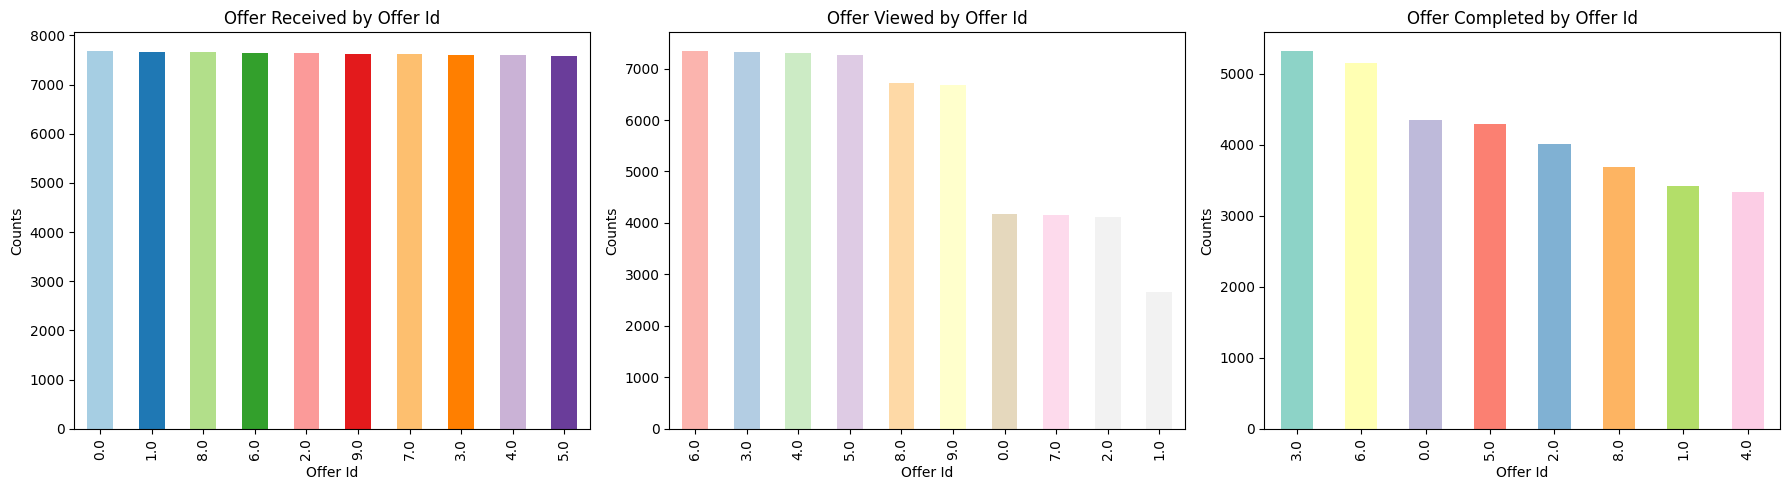

In [62]:

# Create a figure object
fig = plt.figure(figsize=(18, 5))

# Plot for Offer Received
plt.subplot(131)
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_received.plot(kind='bar', color=plt.cm.Paired(np.arange(len(offer_received))))
plt.ylabel('Counts')
plt.xlabel('Offer Id')
plt.title('Offer Received by Offer Id')

# Plot for Offer Viewed
plt.subplot(132)
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_viewed.plot(kind='bar', color=plt.cm.Pastel1(np.arange(len(offer_viewed))))
plt.ylabel('Counts')
plt.xlabel('Offer Id')
plt.title('Offer Viewed by Offer Id')

# Plot for Offer Completed
plt.subplot(133)
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()
offer_completed.plot(kind='bar', color=plt.cm.Set3(np.arange(len(offer_completed))))
plt.ylabel('Counts')
plt.xlabel('Offer Id')
plt.title('Offer Completed by Offer Id')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


### Observation

- **Equal Offer Distribution:** Every `offer_id` received an equal number of offers.
- **Viewing Ratio:** The viewing ratio decreased for certain `offer_ids` such as 0, 6, 7, and 5.
- **Completion Rate:** The offer completion rate is generally quite decent.


In [63]:
data[data['offer_type']=='bogo'].groupby('customer_id')['offer-received'].count()

customer_id
0009655768c64bdeb2e877511632db8f    3
00116118485d4dfda04fdbaba9a87b5c    4
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    4
0020ccbbb6d84e358d3414a3ff76cffd    6
                                   ..
fff3ba4757bd42088c044ca26d73817a    3
fff7576017104bcc8677a8d63322b5e1    6
fff8957ea8b240a6b5e634b6ee8eafcf    2
fffad4f4828548d1b5583907f2e9906b    9
ffff82501cea40309d5fdd7edcca4a07    3
Name: offer-received, Length: 14992, dtype: int64

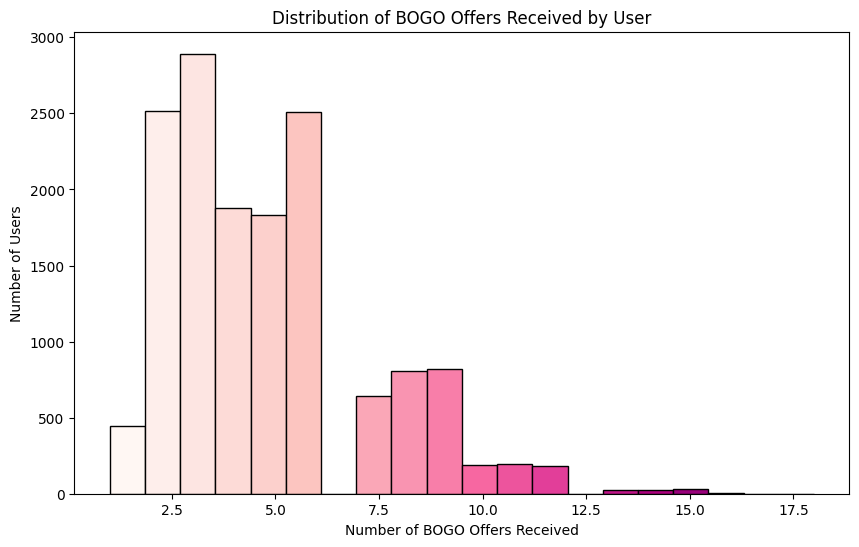

In [68]:
# Plotting the histogram for BOGO offers received by user
plt.figure(figsize=(10, 6))

# Get the counts for BOGO offers received
counts = data[data['offer_type'] == 'bogo'].groupby('customer_id')['offer-received'].count()

# Generate the histogram with different pastel pink colors for each bin
n, bins, patches = plt.hist(counts, bins=20, edgecolor='black')

# Create a pastel pink color gradient manually
colors = [plt.cm.RdPu(i / len(patches)) for i in range(len(patches))]

# Apply pastel pink colors to each bin
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# Set the title and labels
plt.title('Distribution of BOGO Offers Received by User')
plt.xlabel('Number of BOGO Offers Received')
plt.ylabel('Number of Users')

# Display the plot
plt.show()


### Observation

- **BOGO Offer Engagement:** A significant number of users have received the BOGO offer, indicating good user engagement with this type of promotion.


In [69]:

data[data['offer_type']=='informational'].groupby('customer_id')['offer-viewed'].count()

customer_id
0009655768c64bdeb2e877511632db8f    4
0011e0d4e6b944f998e987f904e8c1e5    4
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    2
003d66b6608740288d6cc97a6903f4f0    4
                                   ..
ffecb1f8543f4bf7bade023de366d6bf    2
fff0f0aac6c547b9b263080f09a5586a    4
fff3ba4757bd42088c044ca26d73817a    3
fff8957ea8b240a6b5e634b6ee8eafcf    1
fffad4f4828548d1b5583907f2e9906b    2
Name: offer-viewed, Length: 10547, dtype: int64

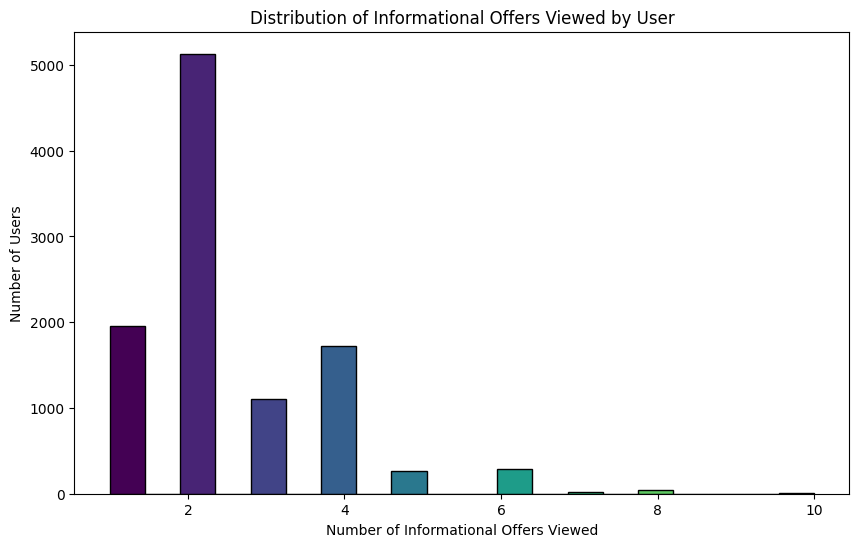

In [70]:
# Plotting the histogram for Informational offers viewed by user
plt.figure(figsize=(10, 6))

# Get the counts for Informational offers viewed
counts = data[data['offer_type'] == 'informational'].groupby('customer_id')['offer-viewed'].count()

# Generate the histogram with different colors for each bin
n, bins, patches = plt.hist(counts, bins=20, edgecolor='black')

# Apply different colors to each bin
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(i / len(patches)))

# Set the title and labels
plt.title('Distribution of Informational Offers Viewed by User')
plt.xlabel('Number of Informational Offers Viewed')
plt.ylabel('Number of Users')

# Display the plot
plt.show()


### Observation

- **High View Ratio:** The ratio of 2 to 4 informational offers viewed per user is notably high.
- **Significant Difference:** There is a substantial difference in the number of users viewing a few offers versus many offers, indicating strong engagement with a subset of users.


In [71]:

data[data['offer_type']=='discount'].groupby('customer_id')['offer-completed'].count()

customer_id
0009655768c64bdeb2e877511632db8f     5
0011e0d4e6b944f998e987f904e8c1e5     6
0020c2b971eb4e9188eac86d93036a77     5
0020ccbbb6d84e358d3414a3ff76cffd     3
003d66b6608740288d6cc97a6903f4f0     8
                                    ..
fff29fb549084123bd046dbc5ceb4faa     3
fff3ba4757bd42088c044ca26d73817a     6
fff7576017104bcc8677a8d63322b5e1     6
fff8957ea8b240a6b5e634b6ee8eafcf     2
ffff82501cea40309d5fdd7edcca4a07    15
Name: offer-completed, Length: 14945, dtype: int64

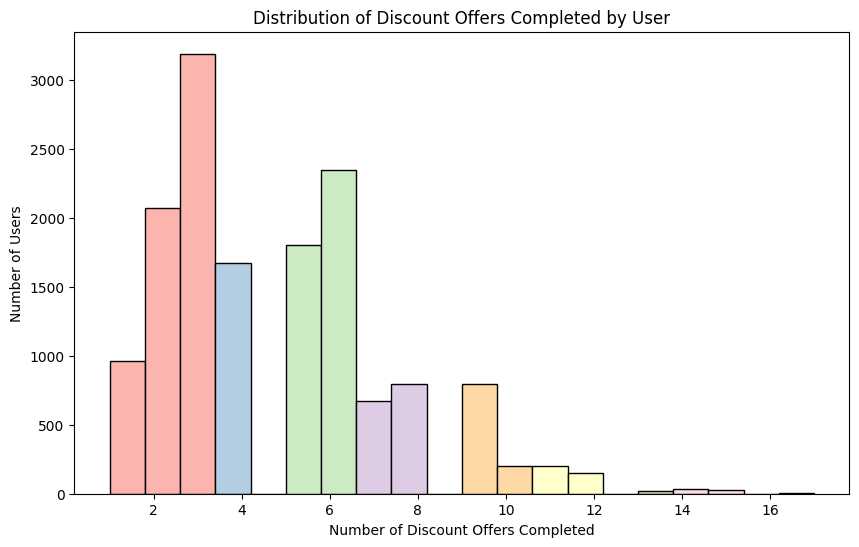

In [72]:
# Plotting the histogram for Discount offers completed by user
plt.figure(figsize=(10, 6))

# Get the counts for Discount offers completed
counts = data[data['offer_type'] == 'discount'].groupby('customer_id')['offer-completed'].count()

# Generate the histogram with pastel colors for each bin
n, bins, patches = plt.hist(counts, bins=20, edgecolor='black')

# Create a pastel color palette (soft colors)
colors = [plt.cm.Pastel1(i / len(patches)) for i in range(len(patches))]

# Apply pastel colors to each bin
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# Set the title and labels
plt.title('Distribution of Discount Offers Completed by User')
plt.xlabel('Number of Discount Offers Completed')
plt.ylabel('Number of Users')

# Display the plot
plt.show()

### Observation

- **High Completion Ratio:** The ratio of customers completing an offer 2 to 4 times is notably high.


### Modeling and Predictions

**Pre-Model Preparation:**
- Apply one-hot encoding to the `Gender` column and the `Offer_type` column to prepare the data for modeling.


In [73]:
# Map gender values to numerical categories
gender_mapping = {'O': 0, 'M': 1, 'F': 2}
data['gender'] = data['gender'].map(gender_mapping)

# Display the value counts for offer types
offer_type_counts = data['offer_type'].value_counts()
print(offer_type_counts)

# Map offer types to numerical categories
offer_type_mapping = {'bogo': 0, 'discount': 1, 'informational': 2}
data['offer_type'] = data['offer_type'].map(offer_type_mapping)


offer_type
bogo             71617
discount         69898
informational    26066
Name: count, dtype: int64


In [74]:
data.head()

,customer_id,event,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,gender,...,income,reward,difficulty,duration,offer_type,email,mobile,social,web,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,False,True,False,False,0.0,NaN,2.0,...,100000.0,5.0,5.0,7.0,0.0,1.0,1.0,0.0,1.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,False,True,False,False,1.0,NaN,NaN,...,NaN,5.0,20.0,10.0,1.0,1.0,0.0,0.0,1.0,0
2,e2127556f4f64592b11af22de27a7932,offer-received,0,False,True,False,False,2.0,NaN,1.0,...,70000.0,2.0,10.0,7.0,1.0,1.0,1.0,0.0,1.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,False,True,False,False,3.0,NaN,NaN,...,NaN,2.0,10.0,10.0,1.0,1.0,1.0,1.0,1.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,False,True,False,False,4.0,NaN,NaN,...,NaN,10.0,10.0,5.0,0.0,1.0,1.0,1.0,1.0,0


In [75]:
data.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [76]:
X = data.drop(['customer_id', 'event_id' , 'event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed', 'transaction'], axis=1)
Y = data['event_id']

In [77]:
X.shape , Y.shape

((306534, 14), (306534,))

### Feature Scaling

**Standardization & Normalization:**

- **Normalization:** This technique scales values so they fall within a range of 0 to 1, also known as Min-Max scaling. It shifts and resizes the data, making it useful when you want to compare different scales of features directly.

- **Standardization:** In this technique, values are centered around the mean and scaled to have a unit standard deviation. This process results in a distribution where the mean is zero and the standard deviation is one, making it useful for algorithms that assume normally distributed data.


In [78]:
# Define class names
class_names = ['offer received', 'offer viewed', 'transaction', 'offer completed']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Display the shapes of the splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to the 'income' and 'age' columns in the training set
X_train['income'] = scaler.fit_transform(X_train['income'].values.reshape(-1, 1))
X_train['age'] = scaler.fit_transform(X_train['age'].values.reshape(-1, 1))

# Reset the index and drop the old index column
X_train.reset_index(drop=True, inplace=True)


(214573, 14) (91961, 14) (214573,) (91961,)


In [79]:
# Apply the same standardization to the 'income' and 'age' columns in the test set
X_test['income'] = scaler.transform(X_test['income'].values.reshape(-1, 1))
X_test['age'] = scaler.transform(X_test['age'].values.reshape(-1, 1))

# Reset the index and drop the old index column
X_test.reset_index(drop=True, inplace=True)


In [80]:
X_train.shape, X_test.shape

((214573, 14), (91961, 14))

In [81]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

### Build a Model 1 

In [86]:
model_keras = keras.models.Sequential()

In [87]:
model_keras.add(keras.layers.Dense(6, activation='relu'))
model_keras.add(keras.layers.Dense(6, activation='relu'))
model_keras.add(keras.layers.Dense(4, activation = 'softmax'))

In [88]:
model_keras.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [89]:
model_keras_history = model_keras.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100 , verbose = 2)

Epoch 1/15
2146/2146 - 6s - 3ms/step - accuracy: 0.4537 - loss: 1.2768 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 2/15
2146/2146 - 5s - 3ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 3/15
2146/2146 - 8s - 4ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 4/15
2146/2146 - 4s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 5/15
2146/2146 - 5s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 6/15
2146/2146 - 3s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 7/15
2146/2146 - 3s - 1ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 8/15
2146/2146 - 3s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 9/15
2146/2146 - 5s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - 

In [90]:
model_keras.summary()   

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 6)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482 (1.89 KB)

 Trainable params: 160 (640.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 322 (1.26 KB)

In [91]:
model_keras.history.params

{'verbose': 2, 'epochs': 15, 'steps': 2146}

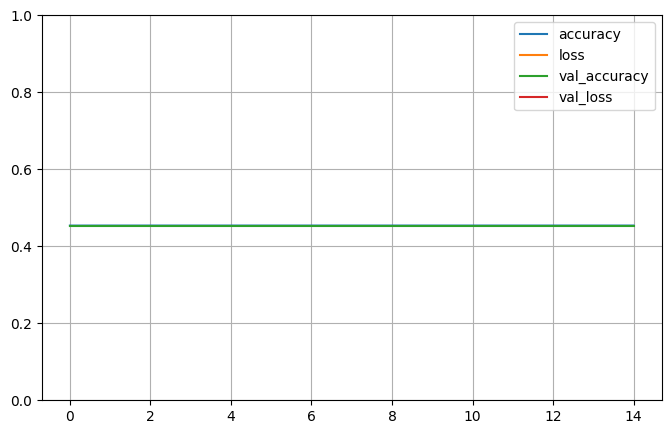

In [92]:
pd.DataFrame(model_keras.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)               # Y AXIS RANGE LIMIT 
plt.show()

### Evaluation Metrics

- **Accuracy:** The model's performance can be evaluated based on the accuracy, which measures the proportion of correctly predicted instances out of the total instances.
- **Loss:** Another key metric is the loss, which indicates how well the model's predictions match the true labels. Lower loss values signify better model performance.


In [103]:
model_keras.evaluate(X_test , y_test)

InvalidArgumentError: Graph execution error:

Detected at node sequential_2_1/dense_6_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\feyza.cotuk\AppData\Local\Temp\ipykernel_592\2573822495.py", line 1, in <module>

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 433, in evaluate

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 165, in one_step_on_iterator

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in one_step_on_data

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 82, in test_step

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\models\sequential.py", line 212, in call

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\models\functional.py", line 560, in call

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\layers\layer.py", line 901, in __call__

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\layers\core\dense.py", line 148, in call

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\activations\activations.py", line 47, in relu

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\activations\activations.py", line 99, in static_call

  File "c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [32,7], In[1]: [14,6]
	 [[{{node sequential_2_1/dense_6_1/Relu}}]] [Op:__inference_one_step_on_iterator_101154]


### Observation:
#### Model Performance:

- **Accuracy:** Achieved ~45.23%, indicating moderate predictive capability.
- **Loss**: Final loss of ~1.2629 suggests room for improvement.

#### Model Complexity:
A simple architecture with 3 layers and 482 trainable parameters, which may limit performance.

#### Next Steps:
Consider tuning hyperparameters or increasing model complexity to enhance accuracy.

### Refinement: Improving Prediction Model

- **Feature Selection:** Create a new `X` DataFrame by selecting highly recommended and dependent features to improve model predictions.
- **Model Enhancement:**
  - **More Hidden Layers:** Add additional hidden layers to the neural network to capture more complex patterns in the data.
  - **More Hidden Units:** Increase the number of neurons in each hidden layer to enhance the model's learning capacity.


In [95]:
data.columns

Index(['customer_id', 'event', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [96]:

X = data.drop(['customer_id', 'event_id' ,  'amount','event' , 'became_member_on','offer-completed', 'offer-received',
       'offer-viewed','email', 'mobile', 'social', 'web', 'time','transaction', 'duration'], axis=1)
Y = data['event_id']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [98]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((214573, 7), (91961, 7), (214573,), (91961,))

In [100]:
# Standardize the 'income' and 'age' columns in the training set
X_train['income'] = scaler.fit_transform(X_train['income'].values.reshape(-1, 1))
X_train['age'] = scaler.fit_transform(X_train['age'].values.reshape(-1, 1))

# Reset the index and drop the old index column
X_train.reset_index(drop=True, inplace=True)


In [101]:
# Standardize the 'income' and 'age' columns in the test set
X_test['income'] = scaler.transform(X_test['income'].values.reshape(-1, 1))
X_test['age'] = scaler.transform(X_test['age'].values.reshape(-1, 1))

# Reset the index and drop the old index column
X_test.reset_index(drop=True, inplace=True)


In [102]:
# Convert the pandas dataframe into numpy array

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

### Build a Model 2

In [106]:
# Initialize the Sequential model
ann = keras.models.Sequential()

# Add the first hidden layer with 32 neurons, specifying input dimensions and ReLU activation
ann.add(keras.layers.Dense(units=32, input_dim=7, kernel_initializer='normal', activation='relu'))

# Add the second hidden layer with 15 neurons and ReLU activation
ann.add(keras.layers.Dense(units=15, kernel_initializer='normal', activation='relu'))

# Add the third hidden layer with 10 neurons and ReLU activation
ann.add(keras.layers.Dense(units=10, kernel_initializer='normal', activation='relu'))

# Add the fourth hidden layer with 6 neurons and ReLU activation
ann.add(keras.layers.Dense(units=6, kernel_initializer='normal', activation='relu'))

# Add the output layer with 4 neurons and softmax activation for multi-class classification
ann.add(keras.layers.Dense(units=4, kernel_initializer='normal', activation='softmax'))

In [107]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [108]:
ann_history = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100 , verbose = 2)

Epoch 1/15
2146/2146 - 5s - 2ms/step - accuracy: 0.4537 - loss: 1.2777 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 2/15
2146/2146 - 6s - 3ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 3/15
2146/2146 - 5s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 4/15
2146/2146 - 5s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 5/15
2146/2146 - 5s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 6/15
2146/2146 - 5s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 7/15
2146/2146 - 7s - 3ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 8/15
2146/2146 - 5s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - val_loss: 1.2629
Epoch 9/15
2146/2146 - 3s - 2ms/step - accuracy: 0.4538 - loss: 1.2609 - val_accuracy: 0.4522 - 

In [109]:
ann.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 15)             │           495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,017 (11.79 KB)

 Trainable params: 1,005 (3.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,012 (7.86 KB)

In [110]:
ann.history.params

{'verbose': 2, 'epochs': 15, 'steps': 2146}

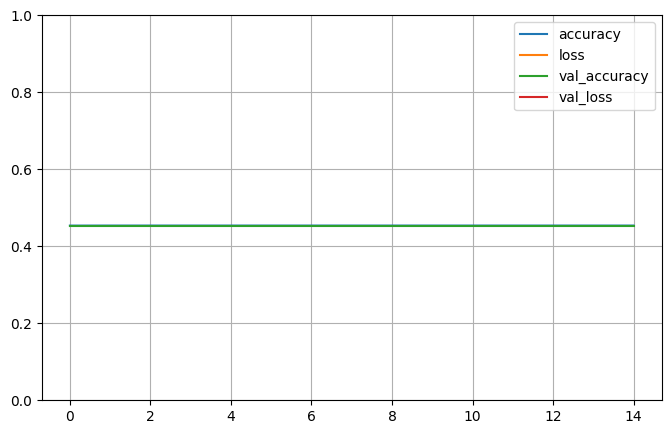

In [111]:
pd.DataFrame(ann.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)               # Y AXIS RANGE LIMIT 
plt.show()

### Evaluation Metrics

- **Accuracy:** The model's performance can be assessed based on the accuracy, which indicates the proportion of correctly predicted instances out of the total instances.
- **Loss:** The loss function provides a measure of how well the model's predictions align with the true labels. Lower loss values indicate better performance.


In [112]:
ann.evaluate(X_test , y_test)

2874/2874 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4543 - loss: 1.2612


[1.2628921270370483, 0.4521590769290924]

In [113]:
# Select a few examples from the test set
x_new = X_test[:3]

# Predict the probabilities for each class
y_prob = ann.predict(x_new)
y_prob = y_prob.round(2)  # Round results to 2 decimal places
print(y_prob)

# Predict the class for each example
y_pred = np.argmax(ann.predict(x_new), axis=-1)
print(y_pred)

# Map the predicted class indices to the class names
class_names = ['offer received', 'offer viewed', 'transaction', 'offer completed']
predicted_classes = np.array(class_names)[y_pred]
print(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[0.25 0.19 0.45 0.11]
 [0.25 0.19 0.45 0.11]
 [0.25 0.19 0.45 0.11]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[2 2 2]
['transaction' 'transaction' 'transaction']


### Observation:

- **Model Architecture:** The model is structured with four hidden layers and one output layer, indicating a deep neural network designed for complex data processing.
  
- **Hidden Layers:**
  - **First Layer:** Consists of 32 neurons, which is a relatively large number for an initial layer, allowing the model to capture a broad range of features from the input data.
  - **Subsequent Layers:** The model then gradually reduces the number of neurons in each hidden layer (15, 10, 6), which helps in refining and focusing the learning process as it progresses through the layers.
  - **ReLU Activation:** All hidden layers use the ReLU activation function, which is a standard choice for deep networks due to its effectiveness in handling non-linear relationships and avoiding issues like vanishing gradients.

- **Output Layer:**
  - **Softmax Activation:** The output layer has 4 neurons, corresponding to 4 possible classes in the classification task. The softmax activation function is used here to output probabilities for each class, which is typical for multi-class classification problems.
  
- **Kernel Initialization:** The use of `kernel_initializer='normal'` across all layers suggests that the model's weights are initialized with values drawn from a normal distribution, which can help in faster convergence during training.

### Summary:
The model appears well-structured for a multi-class classification task, with a gradual reduction in neurons across the layers to focus learning, and a softmax output layer to handle the classification. This architecture should provide a good balance between complexity and performance, allowing the model to learn intricate patterns while maintaining computational efficiency. Further evaluation on training data will reveal how well this architecture performs in practice.
